# Clustering sur le dataset ` DatasetmalwareExtrait `

## Dépendances


In [52]:
# Dépendances data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dépendances Kmeans
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from sklearn.decomposition import PCA

import joblib

# Constantes
DATASET_FILE_PATH:str = '/content/drive/MyDrive/DatasetmalwareExtrait.csv'

In [2]:
# Mettre en place le repertoire de travail
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Analyse de la base de données 'DatasetmalwareExtrait'

Le dataset DatasetmalwareExtrait est une collection de données techniques décrivant des fichiers exécutables, potentiellement liés à des logiciels malveillants. Chaque ligne représente un fichier, caractérisé par plusieurs attributs techniques.  

Il contient les informations suivantes:
- **AddressOfEntryPoint** : Adresse d'entrée principale dans le fichier exécutable.
- **MajorLinkerVersion** : Version majeure de l'éditeur de liens utilisé pour compiler.
- **MajorImageVersion** : Version majeure du fichier exécutable.
- **MajorOperatingSystemVersion** : Version majeure du système d'exploitation cible.
- **DllCharacteristics** : Indicateurs décrivant les caractéristiques des DLL (ex. : sécurité).
- **SizeOfStackReserve** : Taille réservée pour la pile (mémoire d'exécution).
- **NumberOfSections** : Nombre de sections présentes dans le fichier (ex. : code, données).
- **ResourceSize** : Taille totale des ressources intégrées (icônes, images, etc.).  


L'objectif est d'utiliser ce dataset pour developper un modele de classification capable de detecter si un executable .exe est un malware ou non.


## Chargement et Préparation des Données

In [38]:
# Charger le jeu de données
df = pd.read_csv(DATASET_FILE_PATH)
df.head()

,AddressOfEntryPoint,MajorLinkerVersion,MajorImageVersion,MajorOperatingSystemVersion,DllCharacteristics,SizeOfStackReserve,NumberOfSections,ResourceSize,legitimate
0,10407,9,6,6,33088,262144,4,952,1
1,5354,9,6,6,33088,262144,4,952,1
2,58807,9,6,6,33088,262144,4,136490,1
3,25166,9,6,6,33088,262144,4,1940,1
4,70387,9,6,6,33088,262144,4,83098,1


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137444 entries, 0 to 137443
Data columns (total 9 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   AddressOfEntryPoint          137444 non-null  int64
 1   MajorLinkerVersion           137444 non-null  int64
 2   MajorImageVersion            137444 non-null  int64
 3   MajorOperatingSystemVersion  137444 non-null  int64
 4   DllCharacteristics           137444 non-null  int64
 5   SizeOfStackReserve           137444 non-null  int64
 6   NumberOfSections             137444 non-null  int64
 7   ResourceSize                 137444 non-null  int64
 8   legitimate                   137444 non-null  int64
dtypes: int64(9)
memory usage: 9.4 MB


In [40]:
# Suppression des labels
clustering_df = df.loc[:, df.columns != 'legitimate']
legitimate_df = df.loc[:,'legitimate'].to_numpy()
clustering_df.head()

,AddressOfEntryPoint,MajorLinkerVersion,MajorImageVersion,MajorOperatingSystemVersion,DllCharacteristics,SizeOfStackReserve,NumberOfSections,ResourceSize
0,10407,9,6,6,33088,262144,4,952
1,5354,9,6,6,33088,262144,4,952
2,58807,9,6,6,33088,262144,4,136490
3,25166,9,6,6,33088,262144,4,1940
4,70387,9,6,6,33088,262144,4,83098


In [41]:
# Vérification des données manquantes
clustering_df.isnull().sum()

,0
AddressOfEntryPoint,0
MajorLinkerVersion,0
MajorImageVersion,0
MajorOperatingSystemVersion,0
DllCharacteristics,0
SizeOfStackReserve,0
NumberOfSections,0
ResourceSize,0


In [42]:
# Normaliser les données
scaler = StandardScaler()
X = scaler.fit_transform(clustering_df)
y = df['legitimate'].to_numpy()

#Recherche du nombre de cluster

In [8]:
k_range = range(1, 11)  # Essayer de 1 à 10 clusters
inertias = []
sil_scores = []

# Boucle pour calculer l'inertie et le silhouette score pour chaque K
for k in k_range:
    kmeans = KMeans(init='k-means++', n_clusters=k, random_state=42)
    kmeans.fit(X)

    # Inertie pour la méthode du coudé
    inertias.append(kmeans.inertia_)

    # Silhouette Score pour évaluer la qualité du clustering
    if k > 1:  # Le Silhouette Score est indéfini pour k=1
        sil_score = silhouette_score(X, kmeans.labels_)
        sil_scores.append(sil_score)
    else:
        sil_scores.append(None)

In [13]:
joblib.dump(sil_scores, 'sil_scores.dump')

['sil_scores.dump']

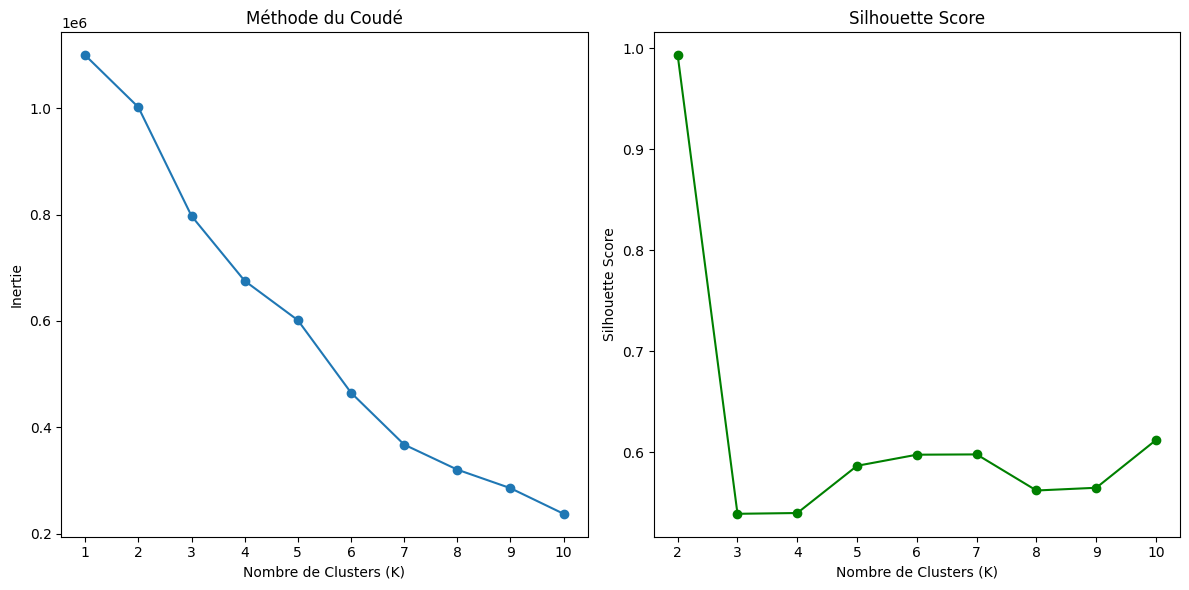

In [43]:
# Visualisation de la méthode du coudé
plt.figure(figsize=(12, 6))

# Subplot 1: Inertie (méthode du coudé)
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o')
plt.title('Méthode du Coudé')
plt.xlabel('Nombre de Clusters (K)')
plt.ylabel('Inertie')
plt.xticks(k_range)

# Subplot 2: Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_range[1:], sil_scores[1:], marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Nombre de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range[1:])

plt.tight_layout()
plt.show()

Nous remarquons une cassure en 3 qui se trouve être le véritable nombre de labels .  
Nous choisirons 3 pour K

# K-Means classique

In [10]:
kmeans = KMeans(init='random', n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Évaluation
silhouette_kmeans = silhouette_score(X, kmeans_labels)
calinski_kmeans = calinski_harabasz_score(X, kmeans_labels)
davies_kmeans = davies_bouldin_score(X, kmeans_labels)

print(f"K-Means - Silhouette: {silhouette_kmeans}, Calinski-Harabasz: {calinski_kmeans}, Davies-Bouldin: {davies_kmeans}")

K-Means - Silhouette: 0.5389443515934719, Calinski-Harabasz: 26032.20935060091, Davies-Bouldin: 0.6677554248767797


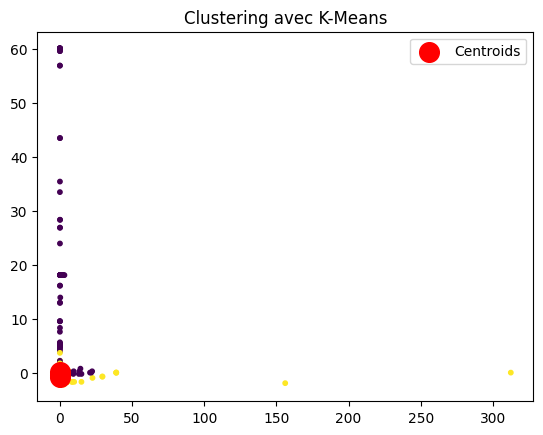

In [14]:
# Visualisation
plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', label='Centroids')
plt.title("Clustering avec K-Means")
plt.legend()
plt.show()

In [15]:
clustered_df = df.copy(deep=True)
clustered_df.loc[:, 'K-meansLabels'] = kmeans_labels
clustered_df.head()

,AddressOfEntryPoint,MajorLinkerVersion,MajorImageVersion,MajorOperatingSystemVersion,DllCharacteristics,SizeOfStackReserve,NumberOfSections,ResourceSize,legitimate,K-meansLabels
0,10407,9,6,6,33088,262144,4,952,1,0
1,5354,9,6,6,33088,262144,4,952,1,0
2,58807,9,6,6,33088,262144,4,136490,1,0
3,25166,9,6,6,33088,262144,4,1940,1,0
4,70387,9,6,6,33088,262144,4,83098,1,0


# Mini Batch K-Means

In [16]:
# Initialisation de l'algorithme Mini-Batch K-Means
mini_batch_kmeans = MiniBatchKMeans(n_clusters=3, batch_size=100, random_state=42)

# Apprentissage des clusters
mini_batch_kmeans_labels = mini_batch_kmeans.fit_predict(X)

# Évaluation
silhouette_mini_batch_kmeans = silhouette_score(X, mini_batch_kmeans_labels)
calinski_mini_batch_kmeans = calinski_harabasz_score(X, mini_batch_kmeans_labels)
davies_mini_batch_kmeans = davies_bouldin_score(X, mini_batch_kmeans_labels)

print(f"Mini batch K-Means - Silhouette: {silhouette_mini_batch_kmeans}, Calinski-Harabasz: {calinski_mini_batch_kmeans}, Davies-Bouldin: {davies_mini_batch_kmeans}")

Mini batch K-Means - Silhouette: 0.5046707601181376, Calinski-Harabasz: 16550.35243880344, Davies-Bouldin: 1.1867043446238934


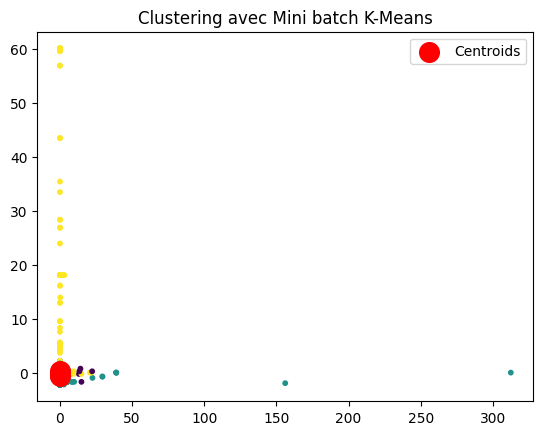

In [17]:
# Visualisation
plt.scatter(X[:, 0], X[:, 1], c=mini_batch_kmeans_labels, cmap='viridis', s=10)
plt.scatter(mini_batch_kmeans.cluster_centers_[:, 0], mini_batch_kmeans.cluster_centers_[:, 1], s=200, c='red', label='Centroids')
plt.title("Clustering avec Mini batch K-Means")
plt.legend()
plt.show()

In [18]:
clustered_df.loc[:, 'MiniBatchK-meansLabels'] = mini_batch_kmeans_labels
clustered_df.head()

,AddressOfEntryPoint,MajorLinkerVersion,MajorImageVersion,MajorOperatingSystemVersion,DllCharacteristics,SizeOfStackReserve,NumberOfSections,ResourceSize,legitimate,K-meansLabels,MiniBatchK-meansLabels
0,10407,9,6,6,33088,262144,4,952,1,0,2
1,5354,9,6,6,33088,262144,4,952,1,0,2
2,58807,9,6,6,33088,262144,4,136490,1,0,2
3,25166,9,6,6,33088,262144,4,1940,1,0,2
4,70387,9,6,6,33088,262144,4,83098,1,0,2


# K-Means ++

In [20]:
kmeans_plus_plus = KMeans(init='k-means++', n_clusters=3, random_state=42)
kmeans_plus_plus_labels = kmeans_plus_plus.fit_predict(X)

# Évaluation
silhouette_kmeans_plus_plus = silhouette_score(X, kmeans_labels)
calinski_kmeans_plus_plus = calinski_harabasz_score(X, kmeans_labels)
davies_kmeans_plus_plus = davies_bouldin_score(X, kmeans_labels)

print(f"K-Means++ - Silhouette: {silhouette_kmeans_plus_plus}, Calinski-Harabasz: {calinski_kmeans_plus_plus}, Davies-Bouldin: {davies_kmeans_plus_plus}")

K-Means++ - Silhouette: 0.5389443515934719, Calinski-Harabasz: 26032.20935060091, Davies-Bouldin: 0.6677554248767797


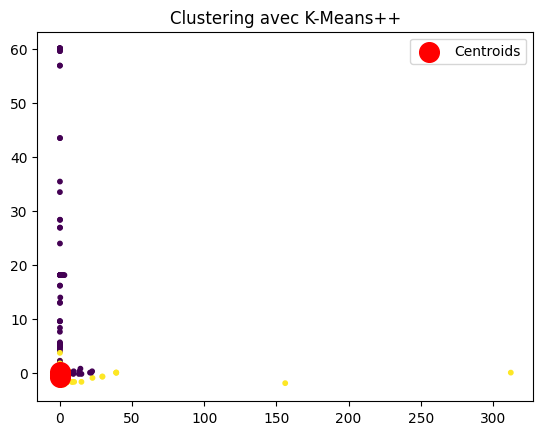

In [27]:
# Visualisation
plt.scatter(X[:, 0], X[:, 1], c=kmeans_plus_plus_labels, cmap='viridis', s=10)
plt.scatter(kmeans_plus_plus.cluster_centers_[:, 0], kmeans_plus_plus.cluster_centers_[:, 1], s=200, c='red', label='Centroids')
plt.title("Clustering avec K-Means++")
plt.legend()
plt.show()

In [22]:
clustered_df.loc[:, 'K-means++Labels'] = kmeans_plus_plus_labels
clustered_df.head()

,AddressOfEntryPoint,MajorLinkerVersion,MajorImageVersion,MajorOperatingSystemVersion,DllCharacteristics,SizeOfStackReserve,NumberOfSections,ResourceSize,legitimate,K-meansLabels,MiniBatchK-meansLabels,K-means++Labels
0,10407,9,6,6,33088,262144,4,952,1,0,2,0
1,5354,9,6,6,33088,262144,4,952,1,0,2,0
2,58807,9,6,6,33088,262144,4,136490,1,0,2,0
3,25166,9,6,6,33088,262144,4,1940,1,0,2,0
4,70387,9,6,6,33088,262144,4,83098,1,0,2,0


In [26]:
clustered_df.to_csv('clustered.csv', sep=',', index=False, encoding='utf-8')

# Superposition du labélisation de base avec le résultat de chaque clustering

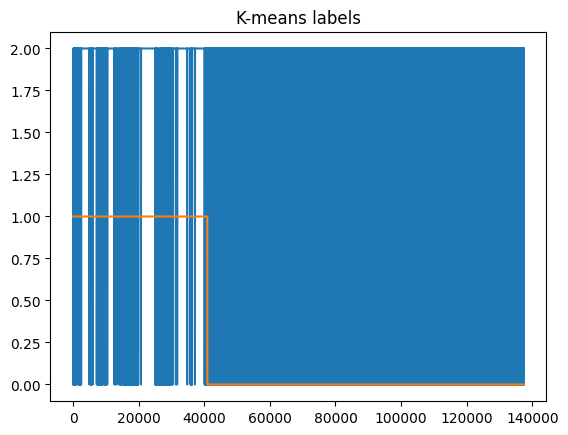

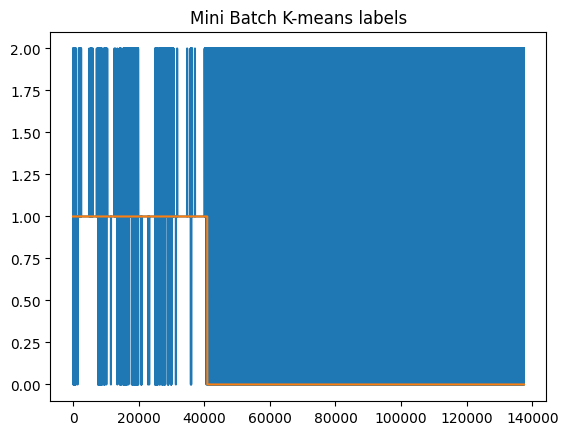

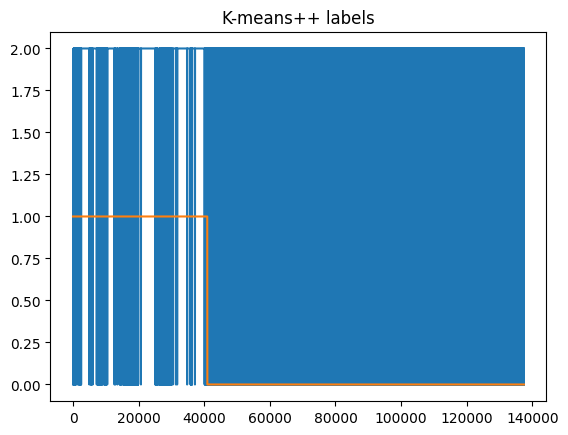

In [51]:
x = range(1, len(clustered_df.loc[:, 'K-means++Labels'].to_numpy())+1)

plt.plot(x, clustered_df.loc[:, 'K-meansLabels'])
plt.plot(x, y)
plt.title('K-means labels')
plt.show()

plt.plot(x, clustered_df.loc[:, 'MiniBatchK-meansLabels'])
plt.plot(x, y)
plt.title('Mini Batch K-means labels')
plt.show()

plt.plot(x, clustered_df.loc[:, 'K-means++Labels'])
plt.plot(x, y)
plt.title('K-means++ labels')
plt.show()

#Comparaison

In [23]:
# Comparaison des métriques
results = pd.DataFrame({
    "Algorithm": ["K-Means", "MiniBatchK-Means", "K-Means++"],
    "Silhouette": [silhouette_kmeans, silhouette_mini_batch_kmeans, silhouette_kmeans_plus_plus],
    "Calinski-Harabasz": [calinski_kmeans, calinski_mini_batch_kmeans, calinski_kmeans_plus_plus],
    "Davies-Bouldin": [davies_kmeans, davies_mini_batch_kmeans, davies_kmeans_plus_plus]
})
results

,Algorithm,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,K-Means,0.538944,26032.209351,0.667755
1,MiniBatchK-Means,0.504671,16550.352439,1.186704
2,K-Means++,0.538944,26032.209351,0.667755


In [24]:
results.to_csv('results.csv', sep=',', index=False, encoding='utf-8')